In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'interspecies_development'
os.environ["DJ_SCHEMA_NAME"] = f"konstantin_nnsysident_{name}"

In [3]:
import re
import torch
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)
from collections import OrderedDict, Iterable
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import hiplot as hip
from scipy.spatial import ConvexHull

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders, static_loaders, static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer, TestCorr, TestCorrTransfer
from nnsysident.utility.measures import get_fraction_oracles, get_correlations

from dataport.bcm.static import PreprocessedMouseData

<ipython-input-3-ecbd964c6b73>:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import OrderedDict, Iterable


Connecting konstantin@134.2.168.16:3306


---

In [4]:
experiment_names = ['Transfer between areas']

# Fetch data
data_transfer = pd.DataFrame()
for experiment_name in experiment_names:
    data_transfer_ = pd.DataFrame(((TrainedModelTransfer * 
                           ExperimentsTransfer.Restrictions & 
                           'experiment_name="{}"'.format(experiment_name)) *
                          Dataset * Model * Trainer * Transfer * OracleScoreTransfer * TestCorrTransfer * Seed ).fetch())
    data_transfer = pd.concat([data_transfer, data_transfer_])

# # Get labels
data_transfer["target data"] = data_transfer.apply(lambda row: row['dataset_comment'].split("Transfer dataset: ")[1].split(" neurons (218)")[0] , axis=1)
data_transfer["origin data (used for core)"] = data_transfer.apply(lambda row: row['transfer_comment'].split(" core")[0] , axis=1)    
data_transfer = pd.concat([data_transfer, data_transfer['dataset_config'].apply(pd.Series)], axis = 1)
data_transfer['areas'] = data_transfer.apply(lambda row: row['areas'][0], axis=1)
data_transfer['layers'] = data_transfer.apply(lambda row: row['layers'][0], axis=1)

data_transfer.drop(columns=['dataset_comment', 'transfer_comment'], inplace=True)


# Filter out best performing models over model seeds
data_transfer = data_transfer.sort_values('score', ascending=False).drop_duplicates(['target data', 'origin data (used for core)', 'neuron_base_seed'])
data_transfer = data_transfer[['target data', 
                               'origin data (used for core)', 
                               'test_correlation', 
                               'neuron_base_seed', 
                               'score', 
                               'fraction_oracle',
                               'model_hash',
                               'dataset_hash', 
                               'trainer_hash',
                               'transfer_hash']].reset_index(drop=True)

# df = data_transfer.copy()
# data_transfer = data_transfer.loc[data_transfer['neuron_base_seed'] == 1]
# data_transfer = data_transfer.groupby(['target data', 'origin data (used for core)'], as_index=False).mean()

# data_transfer = data_transfer.pivot(index="origin data (used for core)", columns='target data', values='fraction_oracle')
# data_transfer = (data_transfer/data_transfer.max()*100).round(1)
# data_transfer = data_transfer.round(2)

In [5]:
experiment_names = ['Direct training on transfer dataset']

# Fetch data
data_direct = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame(((TrainedModel * 
                           Experiments.Restrictions & 
                           'experiment_name="{}"'.format(experiment_name)) *
                          Dataset * Model * Trainer * Transfer * OracleScore * TestCorr * Seed ).fetch())
    data_direct = pd.concat([data_direct, data_])

# # Get labels
data_direct = data_direct.rename(columns={"seed": "overall_seed"})
data_direct = pd.concat([data_direct, data_direct['dataset_config'].apply(pd.Series)], axis = 1)
data_direct['areas'] = data_direct.apply(lambda row: row['areas'][0], axis=1)
data_direct['layers'] = data_direct.apply(lambda row: row['layers'][0], axis=1)
data_direct['target data'] = data_direct['areas']

data_direct.drop(columns=['dataset_comment', 'transfer_comment'], inplace=True)

# Filter out best performing models over model seeds
data_direct = data_direct.sort_values('score', ascending=False).drop_duplicates(['dataset_hash'])
data_direct = data_direct[['target data', 'test_correlation', 'neuron_base_seed', 'overall_seed']].rename(columns={'test_correlation': 'test_correlation_direct'}).reset_index(drop=True)

In [18]:
data = pd.merge(data_transfer, data_direct, on=['target data', 'neuron_base_seed'])
data['normalized_test_corrs'] = data['test_correlation']/data['test_correlation_direct']

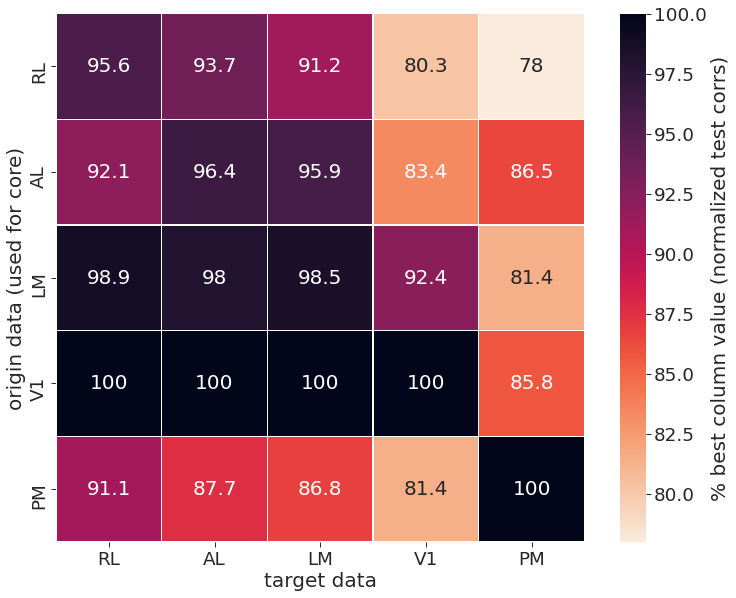

In [22]:
values = 'normalized_test_corrs'
['RL', 'AL', 'LM', 'V1', 'PM']
# df = data.loc[data['neuron_base_seed'] == 2]
df = data.groupby(['target data', 'origin data (used for core)'], as_index=False).mean()

df = df.pivot(index="origin data (used for core)", columns='target data', values=values)
df = (df/df.max()*100).round(1)
df = df.round(2)

order = ['RL', 'AL', 'LM', 'V1', 'PM']
df = df[order].reindex(order)

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):   
    fig, axes = plt.subplots(figsize=(13, 10), dpi=70)
    sns.heatmap(df, 
                annot=True,
                fmt="g", 
                cmap='rocket_r',
                ax=axes, 
                linewidths=.5,
                square=True,
                cbar_kws={'label': '% best column value ({})'.format(values.replace('_', ' '))})
    fig.savefig('figures/inter_area.png', bbox_inches='tight')

### Area Plot

In [ ]:
origin_area = 'PM'
neuron_base_seed = 1
df = data.loc[(data['neuron_base_seed'] == neuron_base_seed) & (data['origin data (used for core)'] ==  origin_area)]

# Calculate per neuron correlations
dpn = pd.DataFrame()
for area in np.unique(df['target data']):
    dpn_ = pd.DataFrame()
    
    df_ = df.loc[df['target data'] == area]
    key = df_[['model_hash', 'dataset_hash', 'trainer_hash', 'transfer_hash']].to_dict(orient="records")[0]
    
    dataloaders, model = (TrainedModelTransfer & key).load_model()
    test_corrs_transfer = get_correlations(model=model, dataloaders=dataloaders['test'])
    cortex_positions = list(dataloaders['test'].values())[0].dataset.neurons.cell_motor_coordinates[:, :-1]  # ignore the z dimension
    
    dataloaders, model = (TrainedModel & 'dataset_hash = "{}"'.format(key["dataset_hash"]) & 'seed = {}'.format(df_.overall_seed.values[0])).load_model()
    test_corrs_direct = get_correlations(model=model, dataloaders=dataloaders['test'])

    dpn_['test_corrs_transfer'] = test_corrs_transfer
    dpn_['test_corrs_direct'] = test_corrs_direct

    dpn_['cortex_positions_x'] = cortex_positions[:, 0]
    dpn_['cortex_positions_y'] = cortex_positions[:, 1]
    dpn_['area'] = area
    dpn = pd.concat([dpn, dpn_])
dpn['normalized_test_corr'] = dpn['test_corrs_transfer']/dpn['test_corrs_direct']

In [ ]:
quantile = 0.80
vmin = dpn.normalized_test_corr.quantile(1-quantile)
vmax = dpn.normalized_test_corr.quantile(quantile)
plot_dpn = dpn.loc[(dpn['normalized_test_corr'] > vmin) & (dpn['normalized_test_corr'] < vmax)]

hue = 'normalized_test_corr'
x = 'cortex_positions_y'
y = 'cortex_positions_x'
cluster_colors = list(sns.color_palette('bright'))[:5]

##################################################################################################
def encircle(x, y, area, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)
    cx = np.mean(hull.points[hull.vertices,0])
    cy = np.mean(hull.points[hull.vertices,1])
    ax.text(cx, cy, area, fontsize=40, ha='center', va='center', weight='bold', alpha=0.7)

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15),  sns.axes_style('ticks'):   
    
    fig, axes = plt.subplots(figsize=(15, 15), dpi=70)
    g = sns.scatterplot(x=x, y=y, hue=hue, data=plot_dpn, ax=axes, palette="coolwarm")
    g.legend(loc='center left', frameon=True, bbox_to_anchor=(0.95, 0.4), ncol=1, title='change wrt. \ndirect training')
    
    for area in np.unique(dpn.area):
        data_ = plot_dpn.loc[plot_dpn['area'] == area] 
        lw=3. if origin_area !=area else 10.
        encircle(data_[x], data_[y], area, ec='k', fc="none", lw=lw)
        
    plt.axis('off')
    sns.despine(trim=True)
#     fig.savefig(f'figures/transfer_cortex_map_{origin_area}.png', bbox_inches='tight')

---

In [23]:
def fraction_of_shell(N, epsilon_over_r):
    return 1-(1-epsilon_over_r)**N

In [29]:
N = 2
epsilon_over_r = 0.5

print(fraction_of_shell(N, epsilon_over_r))

0.75
